## 0. 라이브러리 IMPORT

In [62]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))
import cv2 
import numpy as np 
import imutils 
import matplotlib.pyplot as plt 
from os import listdir
import os 
from collections import Counter
import pandas as pd
from easydict import EasyDict as edict
%matplotlib inline 
plt.rcParams["figure.figsize"] = (10, 8)

## 1. 필요한 함수들 선언

In [63]:
def show_two_images(img1, img2):
    rows, cols = 1, 2
    fig = plt.figure()
    ax1 = fig.add_subplot(rows, cols, 1)
    ax1.axis('off')
    ax1.imshow(img1)
    ax2 = fig.add_subplot(rows, cols, 2)
    ax2.axis('off')
    ax2.imshow(img2)
    plt.show()
    
def set_approx(x, y, w, h):
    approx = np.zeros((4, 1, 2), dtype=np.int32)
    approx[0][0][0], approx[0][0][1] = x+w, y
    approx[1][0][0], approx[1][0][1] = x+w, y+h
    approx[2][0][0], approx[2][0][1] = x, y+h
    approx[3][0][0], approx[3][0][1] = x, y
    return approx

def drop_dupli_lines(lines: list, diff: int):
    lines.append(0)
    lines.sort()
    line_diff = []
    for i,j in enumerate([lines[i+1]-lines[i] for i in range(len(lines)-1)]):
        if j > diff:
            line_diff.append(lines[i+1])
    return line_diff

def split_list(arr, size):
     arrs = []
     while len(arr) > size:
         pice = arr[:size]
         arrs.append(pice)
         arr   = arr[size:]
     arrs.append(arr)
     return arrs

def draw_bbox(image, len_approx_range, area_range, ratio_range):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
#     image = cv2.resize(image, (1000, 800))
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    clahe = cv2.createCLAHE(clipLimit=2., tileGridSize=(16, 16))
    gray = clahe.apply(gray)
    bfilter = cv2.bilateralFilter(gray, 11, 17, 17)
    edged = cv2.Canny(bfilter, 30, 200) 

    _, thresh = cv2.threshold(edged.copy(), 200, 255, cv2.THRESH_BINARY) 

    mask = thresh.copy()

    dilate_cnts = cv2.findContours(
        mask, 
        cv2.RETR_EXTERNAL, 
        cv2.CHAIN_APPROX_SIMPLE
    )
    
    ret_img = image.copy()
    candidates = list()
    cont_area = list()
    for c in imutils.grab_contours(dilate_cnts): 
        peri = cv2.arcLength(c, True) # 외곽선 길이를 반환
        approx = cv2.approxPolyDP(c, 0.018 * peri, True) # 외곽선을 근사화(단순화) 합니다.
        approx = cv2.convexHull(approx) # 주어진 점으로부터 컨벡스 헐을 반환
        area = cv2.contourArea(approx) #  외곽선이 감싸는 영역의 면적을 반환
        
        x, y, w, h = cv2.boundingRect(approx)  # 주어진 점을 감싸는 최소 크기 사각형(바운딩 박스)를 반환
        
        if not (len_approx_range[0] <= len(approx) <= len_approx_range[1]): continue
        if not (area_range[0] < w * h < area_range[1]): continue
        if not (ratio_range[0] < h/w < ratio_range[1]): continue
        
        approx = np.zeros((4, 1, 2), dtype=np.int32)
        approx[0][0][0], approx[0][0][1] = x+w, y
        approx[1][0][0], approx[1][0][1] = x+w, y+h
        approx[2][0][0], approx[2][0][1] = x, y+h
        approx[3][0][0], approx[3][0][1] = x, y
        
        candidates.append([approx, w, h])
        cont_area.append([area,cv2.boundingRect(approx)])
        
        cv2.drawContours(ret_img, [approx], -1, (0, 255, 0), 2) 
    return ret_img, candidates, cont_area

def detect_recog_points(img, criteria_list):
    y_ = criteria_list[0][1]
    w_ = criteria_list[0][2]
    h_ = criteria_list[0][3]
    image_b = img[y_:y_+h_,:]
    image_b = cv2.cvtColor(image_b, cv2.COLOR_BGR2GRAY)
    (thresh, image_b) = cv2.threshold(image_b, 127, 255, cv2.THRESH_BINARY)
    image_b = cv2.transpose(image_b)
    y_list =  [i for i in range(image_b.shape[0]) if np.sum(image_b[i]) != 255*h_]
    y_list =  drop_dupli_lines(y_list, 1)
    return y_list

## 2. IMAGE & 좌표값 JSON LIST

In [64]:
OMR_LIST = {
    'No03': {
        'picture' : '3-1.jpg',
        'y_start' : 765,
        'margin' : 16,
        ## [x값 좌표]
        'answer_list_x' : [[17,23],[23,29],[29,35]],
        ## [y좌표, y간격]
        'answer_list_y' : [[7,41],3],
        ## 답안칸 문항 개수
        'answer_number' : [12,12,12],
        'peronal_info' : {
            ## [x좌표, y좌표, y간격, 0 or 1]
            'sex' : [[2,6],17,0],
            'grade' : [1,[27,45],2,0],
            'birth' : [[2,8],[25,45],2,1],
            'name' : [[8,17],[6,47],2,1],
        }
    },
    'No05': {
        'picture' : '5-1.jpg',
        'y_start' : 786,
        'margin' : 16,
        'answer_list_x' : [[20,22],[22,24],[24,26],[26,29],[29,32],[32,35],[35,38],[38,41],[41,44],[44,49],[49,54]],
        'answer_list_y' : [[9,14],[15,20],[21,26],[27,32],[33,38],[39,44],1],
        'answer_number' : [30,30,30,30,30,24,24,30,30,30,15],
    },
    'No06': {
        'picture' : '6-1.jpg',
        'y_start' : 789,
        'margin' : 16,
        'answer_list_x' : [],
        'answer_list_y' : [],
        'answer_number' : [],
    },
    'No07': {
        'picture' : '7-1.jpg',
        'y_start' : 770,
        'margin' : 16,
        'answer_list_x' : [[18,25],[25,32]],
        'answer_list_x_2' : [[32,34],[34,36],[36,38],[38,40]],
        'answer_list_y' : [[5,15],[16,26],[27,37],[38,48],1],
        'answer_list_y_2' : [[10,20],[24,34],[38,48],1],
        'answer_number' : [40,35],
        'answer_number_2' : [30,30,30,30],
    },
    'No09': {
        'picture' : '9-1.jpg',
        'y_start' : 768,
        'margin' : 16,
        'answer_list_x' : [[20,24],[24,28],[28,32],[32,36],[36,40]],
        'answer_list_y' : [[8,13],[14,19],[20,25],[26,31],[32,37],[38,43],1],
        'answer_number' : [30,30,30,30,26],
    },
    'No13': {
        'picture' : '13-1.jpg',
        'y_start' : 787,
        'margin' : 16,
        'margin_2' : 0,
        'answer_list_x' : [[16,21],[21,26],[26,31]],
        'answer_list_x_2' : [[31,41]],
        'answer_list_y' : [[10,15],[16,21],[22,27],[28,33],[34,39],[40,45],1],
        'answer_list_y_2' : [[11,23],[24,36],[37,49],2],
        'answer_number' : [30,30,30],
        'answer_number_2' : [18],
        'peronal_info' : {
            'sex' : [6,[13,15],1,0],
            'univ_YN' : [3,[13,15],1,0],
            'birth' : [[1,7],[35,45],1,1],
            'grade' : [2,[21,25],1,0],
            'grade_no' : [[3,7],[20,30],1,1],
            'name' : [[7,16],[27,48],1,1],
        }
    },
    'No15': {
        'picture' : '15-1.jpg',
        'y_start' : 771,
        'margin' : 16,
        'margin_2' : 0,
        'answer_list_x' : [[20,25],[25,30],[30,35]],
        'answer_list_y' : [[10,15],[16,21],[22,27],[28,33],[34,39],[40,45],1],
        'answer_number' : [30,30,20],
        'peronal_info' : {
            'sex' : [[5,9],15,0],
            'birth' : [[1,7],[21,31],1,1],
            'grade' : [8,[21,25],1,0],
            'grade_div' : [8,[29,31],1,0],
            'std_id' : [[1,11],[36,46],1,1],
            'name' : [[11,20],[25,46],1,1],
        },
    },
    'No19': {
        'picture' : '19-1.jpg',
        'y_start' : 787,
        'margin' : 16,
        'answer_list_x' : [[20,25],[25,30],[30,35],[35,40]],
        'answer_list_y' : [[10,15],[16,21],[22,27],[28,33],[34,39],[40,45],1],
        'answer_number' : [30,30,30,25],
        'peronal_info' : {
            'sex' : [[5,9],15,0],
            'birth' : [[1,7],[21,31],1,1],
            'grade' : [8,[21,25],1,0],
            'grade_div' : [8,[29,31],1,0],
            'std_id' : [[1,11],[36,46],1,1],
            'name' : [[11,20],[25,46],1,1],
        }
    },
}

In [67]:
###################### 좌표 따는 용 코드 ######################
test_img = image.copy()
y_val =  OMR_LIST['No03']['y_start']
margin = 16
line_list = sorted([(y_val - i*margin) for i in range(y_val//margin)])
x1, y1 = 0, y_val
x2, y2 = image.shape[1], y_val
y_points = list()
# for line in line_list:
#     x1, x2 = 0, 1170
#     y1, y2 = line, line
#     cv2.line(test_img, (x1, y1), (x2, y2), (0, 255, 0), thickness=1)
    
test_y = line_list[6:47:2] #10 20 24 34
# print(questions_y) 
for i in test_y:
    cv2.line(test_img, (x1, i), (x2, i), (0, 255, 0), thickness=1)
    
cv2.imshow('dd',test_img)
cv2.waitKey(0)
cv2.destroyAllWindows()
###################### 좌표 따는 용 코드 ######################

## 3. 이미지 불러오기

In [70]:
DATA_DIR = os.path.join(os.getcwd(),'omrs','06')
image_path = os.path.join(DATA_DIR, OMR_LIST['No03']['picture'])
image = cv2.imread(image_path)
image_a = image.copy()

## 4. Recognition Point Detection (Get X Coordinates)

y_list : 36  /  criteria_list = 36


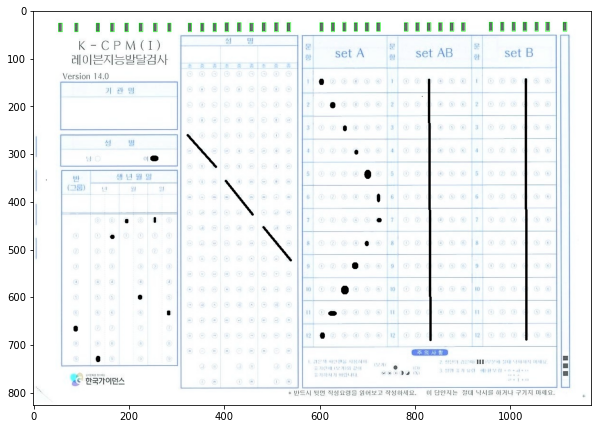

In [71]:
def draw_recogntion_point(real_data):
    len_approx_range = (4, 8)
    area_range = (50, 250)
    ratio_range = (1.5, 5)
    criteria_list = list()
    recognition_points = list()
      
    recog_img, recog_cand, recog_area = draw_bbox(real_data, len_approx_range, area_range, ratio_range)
    
    recog_y_point = [i[1][1] for i in recog_area]
    y_cnt = dict(Counter(recog_y_point))
    y_criteria = sorted(y_cnt.items(), key=lambda item: -item[1])[0][0]
    recognition_coord = list()
    for coord, w, h in recog_cand:
        x, y = coord[-1][0]
        if abs(y_criteria - y) <= 3: 
            criteria_list.append([x, y, w, h])
    criteria_list = sorted(criteria_list, key=lambda x: x[0])

    y_list = detect_recog_points(image.copy(), criteria_list)
    print(f"y_list : {len(y_list)}  /  criteria_list = {len(criteria_list)}")
    if len(y_list) > len(criteria_list):
        for i in y_list:
            a = [i, criteria_list[0][1], criteria_list[0][2] ,criteria_list[0][3]]
            recognition_points.append(set_approx(*a))
            recognition_coord.append(a)
    else:
        for i in criteria_list:
            recognition_points.append(set_approx(*i))
            recognition_coord.append(i)
    
    cv2.drawContours(image, recognition_points, -1, (0, 255, 0), 1)
    
    return image, recog_cand, recog_area, recognition_coord

recog_img, recog_cand, recog_area, recognition_coord = draw_recogntion_point(image_a)
plt.imshow(recog_img);

## 5. Get Y Coordinates

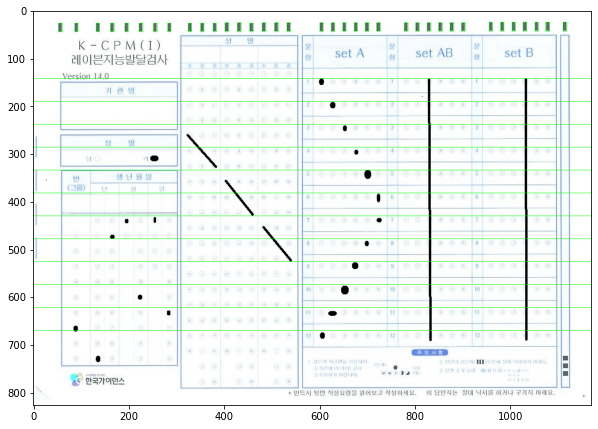

In [72]:
def get_y_coord(image, y_start: int, margin: int, answer_list_y: list, *line_check:False):
    image_xy = image.copy()
    question_x = list()
    question_y = list()
    line_list = sorted([(y_start - i*margin) for i in range(y_start//margin)])
    
    for i in answer_list_y[:-1]:
        question_y += line_list[i[0]:i[1]:answer_list_y[-1]]
            
    if line_check:
        x1, y1 = 0, y_start
        x2, y2 = image_xy.shape[1], y_start
        for i in question_y:
            cv2.line(image_xy, (x1, i), (x2, i), (0, 255, 0), thickness=1)
        plt.imshow(image_xy)
    return question_y

# question_y = get_y_coord(image, OMR_LIST['No13']['y_start'], OMR_LIST['No13']['margin'], OMR_LIST['No13']['answer_list_y'], False, True)
# question_y_2 = get_y_coord(image, OMR_LIST['No13']['y_start'], OMR_LIST['No13']['margin'], OMR_LIST['No13']['answer_list_y_2'], True, True)
# question_y_03 = get_y_coord(image, OMR_LIST['No03']['y_start'], OMR_LIST['No03']['margin'], OMR_LIST['No03']['answer_list_y_2'], True, True)
question_y = get_y_coord(image, OMR_LIST['No03']['y_start'], OMR_LIST['No03']['margin'], OMR_LIST['No03']['answer_list_y'], True)

## 6. OMR 체크 문항들 LIST에 담기

In [73]:
def make_answer_boxes(image, recognition_coord: list, answer_list_x: list, answer_number: list, question_y: list, margin: int):
    image_thresh = cv2.cvtColor(image.copy(), cv2.COLOR_BGR2GRAY)
    (thresh, image_c) = cv2.threshold(image_thresh, 127, 255, cv2.THRESH_BINARY)
    boxes = list()
    for idx, xx in enumerate(answer_list_x):
        question_x = recognition_coord[xx[0]:xx[1]]
        for y in question_y[:answer_number[idx]]:
            for x in question_x:
                x_mid = x[0] + x[2]//2
                half_width = margin//2
                section_img = image_c[y:y+margin, x_mid-half_width:x_mid+half_width]
                boxes.append(section_img)
    return boxes

In [49]:
# boxes = make_answer_boxes(image, recognition_coord, OMR_LIST['No13']['answer_list_x'], OMR_LIST['No13']['answer_number'], question_y, OMR_LIST['No13']['margin'])
# boxes_2 = make_answer_boxes(image, recognition_coord, OMR_LIST['No13']['answer_list_x_2'], OMR_LIST['No13']['answer_number_2'], question_y_2, OMR_LIST['No13']['margin'])
boxes = make_answer_boxes(image, recognition_coord, OMR_LIST['No03']['answer_list_x'], OMR_LIST['No03']['answer_number'], question_y, OMR_LIST['No03']['margin'])
# boxes = make_answer_boxes(image, recognition_coord, OMR_LIST['No19']['answer_list_x'], OMR_LIST['No19']['answer_number'], question_y, OMR_LIST['No19']['margin'])

In [74]:
print(len(boxes))

216


## 7. Print Answers (색비교 후 max index 값 추출)

In [75]:
def print_answer(boxes: list, answer_list_x: list, answer_number: list, *print_box:False):
    answer = list()
    finalVal = list()
    choice_list = [i[1]-i[0] for i in answer_list_x]
    answer_choice_idx = [i*j for i,j in zip(answer_number, choice_list)]
    final_idx = [0] + [sum(answer_choice_idx[:i]) for i in range(1,len(choice_list)+1)]
    for idx in range(len(final_idx)-1):
        temp_ans = list()
        for box in boxes[final_idx[idx]:final_idx[idx+1]]:
            temp_ans.append(np.sum(box == 0))
        answer.append(split_list(temp_ans, choice_list[idx]))
        
    for ans in answer:
        for a in ans:
            finalVal.append(np.argmax(a)+1)
    return answer, finalVal

In [76]:
# answer, finalVal = print_answer(boxes, OMR_LIST['No13']['answer_list_x'], OMR_LIST['No13']['answer_number'])
# answer_2, finalVal_2 = print_answer(boxes_2, OMR_LIST['No13']['answer_list_x_2'], OMR_LIST['No13']['answer_number_2'])
answer_03, finalVal_03 = print_answer(boxes, OMR_LIST['No03']['answer_list_x'], OMR_LIST['No03']['answer_number'])
# answer, finalVal = print_answer(boxes, OMR_LIST['No19']['answer_list_x'], OMR_LIST['No19']['answer_number'])


print(finalVal_03)
# print(finalVal_2)

[1, 2, 3, 4, 5, 6, 6, 5, 4, 3, 2, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4]


## 8. 개인정보 칸 Detection

In [ ]:
def personal_info(image, recognition_coord: list, y_start, instance: list, margin: int):
    image_thresh = cv2.cvtColor(image.copy(), cv2.COLOR_BGR2GRAY)
    (thresh, image_c) = cv2.threshold(image_thresh, 127, 255, cv2.THRESH_BINARY)
    line_list = sorted([(y_start - i*margin) for i in range(y_start//margin)])
    boxes = list()
    answer = list()
    
    # x값만 list형일 때
    if instance[-1] == 0:
        if isinstance(instance[0],list):
            boxes = list()
            xx = [recognition_coord[instance[0][0]], recognition_coord[instance[0][1]]]
            yy = line_list[instance[1]]
            
            half_width = margin//2
            for x in xx:
                x_mid = x[0] + x[2]//2
                section_img = image_c[yy:yy+margin, x_mid-half_width:x_mid+half_width]
                boxes.append(np.sum(section_img==0))
            answer = np.argmax(boxes)+1.
            
        # y값만 list 형일 때
        if isinstance(instance[1],list):
            boxes = list()
            xx = recognition_coord[instance[0]]
            yy = line_list[instance[1][0]:instance[1][1]:instance[-2]]
            x_mid = xx[0] + xx[2]//2
            half_width = margin//2
            for y in yy:
                section_img = image_c[y:y+margin, x_mid-half_width:x_mid+half_width]
                boxes.append(np.sum(section_img==0))
            answer = np.argmax(boxes)+1
            
    # x,y 둘 다 list 형일 때
    if instance[-1] == 1:
        xx = recognition_coord[instance[0][0]:instance[0][1]]
        yy = line_list[instance[1][0]:instance[1][1]:instance[-2]]
        half_width = margin//2
        for x in xx:
            boxes = list()
            x_mid = x[0] + x[2]//2
            for y in yy:
                section_img = image_c[y:y+margin, x_mid-half_width:x_mid+half_width]
                boxes.append(np.sum(section_img==0))
            answer.append(np.argmax(boxes)+1)
    
    return answer
                  
answer = personal_info(image, recognition_coord, OMR_LIST['No03']['y_start'], OMR_LIST['No03']['peronal_info']['name'], OMR_LIST['No03']['margin'])
answer

## 9. 종합 코드

y_list : 36  /  criteria_list = 36
sex : 2
grade : 7
birth : [10, 2, 1, 6, 1, 7]
name : [5, 6, 7, 8, 9, 10, 11, 12, 13]
[1, 2, 3, 4, 5, 6, 6, 5, 4, 3, 2, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4]


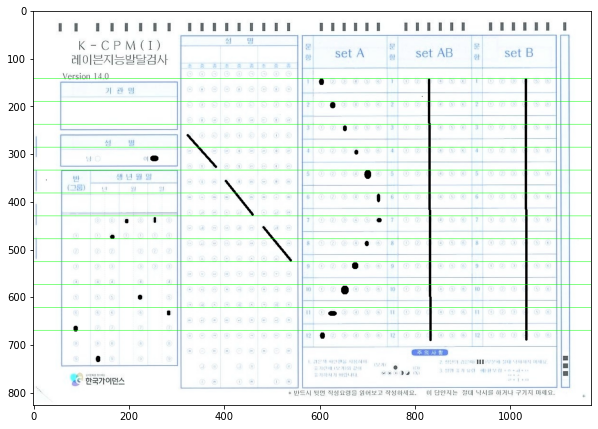

In [60]:
DATA_DIR = os.path.join(os.getcwd(),'omrs','06')
def total_code(img):
    image_path = os.path.join(DATA_DIR, OMR_LIST[img]['picture'])
    image = cv2.imread(image_path)
    image_a = image.copy()
    recog_img, recog_cand, recog_area, recognition_coord = draw_recogntion_point(image_a)
    question_y = get_y_coord(image, OMR_LIST[img]['y_start'], OMR_LIST[img]['margin'], OMR_LIST[img]['answer_list_y'], True)
    boxes = make_answer_boxes(image, recognition_coord, OMR_LIST[img]['answer_list_x'], OMR_LIST[img]['answer_number'], question_y, OMR_LIST[img]['margin'])
    answer, finalVal = print_answer(boxes, OMR_LIST[img]['answer_list_x'], OMR_LIST[img]['answer_number'])
    
    personal_total = list()
    for info in OMR_LIST[img]['peronal_info'].keys():
        ans = personal_info(image, recognition_coord, OMR_LIST[img]['y_start'], OMR_LIST[img]['peronal_info'][info], OMR_LIST[img]['margin'])
        print(f"{info} : {ans}")
        personal_total.append(ans)
        
    return finalVal, personal_total

finalVal, personal_total = total_code('No03')
print(finalVal)
# print(personal_total)

y_list : 36  /  criteria_list = 41
sex : 1
birth : [10, 2, 1, 6, 1, 7]
grade : 4
grade_div : 2
std_id : [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
name : [12, 21, 13, 19, 6, 3, 10, 14, 13]
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 3, 4, 5, 5, 4, 3, 2, 1, 1, 2, 3, 4, 5, 5, 4, 3, 2, 1, 1, 2, 3, 4, 5, 5, 4, 3, 2, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 2, 3, 4, 5, 5, 5, 5, 5, 5, 5, 4, 3, 2, 1, 1, 1, 1, 1, 1, 1, 2, 3, 4, 5]
[1, [10, 2, 1, 6, 1, 7], 4, 2, [1, 2, 3, 4, 5, 6, 7, 8, 9, 10], [12, 21, 13, 19, 6, 3, 10, 14, 13]]


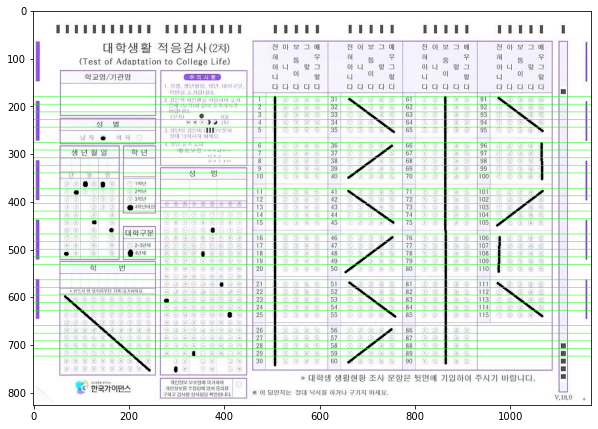

In [61]:
DATA_DIR = os.path.join(os.getcwd(),'omrs','06')
def total_code(img):
    image_path = os.path.join(DATA_DIR, OMR_LIST[img]['picture'])
    image = cv2.imread(image_path)
    image_a = image.copy()
    recog_img, recog_cand, recog_area, recognition_coord = draw_recogntion_point(image_a)
    question_y = get_y_coord(image, OMR_LIST[img]['y_start'], OMR_LIST[img]['margin'], OMR_LIST[img]['answer_list_y'], True)
    boxes = make_answer_boxes(image, recognition_coord, OMR_LIST[img]['answer_list_x'], OMR_LIST[img]['answer_number'], question_y, OMR_LIST[img]['margin'])
    answer, finalVal = print_answer(boxes, OMR_LIST[img]['answer_list_x'], OMR_LIST[img]['answer_number'])
    
    personal_total = list()
    for info in OMR_LIST[img]['peronal_info'].keys():
        ans = personal_info(image, recognition_coord, OMR_LIST[img]['y_start'], OMR_LIST[img]['peronal_info'][info], OMR_LIST[img]['margin'])
        print(f"{info} : {ans}")
        personal_total.append(ans)

    return finalVal, personal_total

finalVal, personal_total = total_code('No19')
print(finalVal)
print(personal_total)

# ---------------------------------------------------------------------------------------------------------------------------

## 99. 이전 코드

In [285]:
def concat_recog_points(image, criteria_list, margin):
    pp = list()
    for y_crit in criteria_list[:5]:
#         section = image[:,y_crit-margin:y_crit+12+margin]
        section = image[:,y_crit:y_crit+20]
#         plt.imshow(section)
#         plt.show()
#         pp.append(section)
#     print(len(pp))
#     plt.imshow(cv2.hconcat(pp))
    
concat_recog_points(image_a, y_list, 5)

In [250]:
def splitBoxes(image, number, choices):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    (thresh, image) = cv2.threshold(image, 127, 255, cv2.THRESH_BINARY)
    image = cv2.resize(image, ((image.shape[1]//choices)*choices, (image.shape[0]//number)*number))
    rows = np.vsplit(image, number)
    boxes=list()
    answers = list()
    for r in rows:
        cols= np.hsplit(r, choices)
        for box in cols:
            boxes.append(box)
            
    finalVal = np.zeros((number, choices))

    cntC, cntR = 0,0
    for i in boxes:
        sel = np.sum(i == 0)
        finalVal[cntR][cntC] = sel
        cntC += 1
        if (cntC == choices): cntR += 1; cntC=0
            
    for i in finalVal:
        answers.append(np.argmax(i)+1)
        
    return answers, finalVal
        
answers, finalVal = splitBoxes(c_img, 12, 6)

answers

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

In [ ]:
sep_image_list

In [309]:
answers, finalVal = splitBoxes(sep_image_list[8], 20, 5)
print(len(answers))
print(answers)

20
[2, 2, 3, 4, 5, 1, 2, 3, 4, 5, 2, 2, 3, 4, 5, 5, 4, 3, 2, 2]


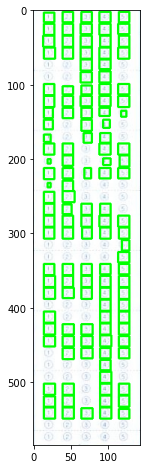

In [251]:
def find_number_contours(img):
    gray = img.copy()
    bfilter = cv2.bilateralFilter(gray, -1, 17, 17)
    edged = cv2.Canny(bfilter, 20, 100) 
    _, thresh = cv2.threshold(edged.copy(), 200, 255, cv2.THRESH_BINARY) 
    mask = thresh.copy()
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 2))
    mask = cv2.dilate(mask, kernel, iterations=1) 


    dilate_cnts = cv2.findContours(
        mask, 
        cv2.RETR_EXTERNAL, 
        cv2.CHAIN_APPROX_SIMPLE
    )

    ret_img = img.copy()
    candidates = list()
    four_points = list()
    area_range = (20, 300)
    ratio_range = (0.75, 1.65)

    for c in imutils.grab_contours(dilate_cnts): 
        peri = cv2.arcLength(c, True) 
        approx = cv2.approxPolyDP(c, 0.018 * peri, True) 

        approx = cv2.convexHull(approx)
        area = cv2.contourArea(approx)
        x, y, w, h = cv2.boundingRect(approx)
        
        """
        if not (len_approx_range[0] <= len(approx) <= len_approx_range[1]): continue
        """
        if not (ratio_range[0] < h/w < ratio_range[1]): continue
        if not (area_range[0] < w * h < area_range[1]): continue

        approx = np.zeros((4, 1, 2), dtype=np.int32)
        approx[0][0][0], approx[0][0][1] = x+w, y
        approx[1][0][0], approx[1][0][1] = x+w, y+h
        approx[2][0][0], approx[2][0][1] = x, y+h
        approx[3][0][0], approx[3][0][1] = x, y

        candidates.append((approx, cv2.boundingRect(approx)))

        cv2.drawContours(ret_img, [approx], -1, (0, 255, 0), 2) 
    plt.imshow(ret_img)
    return ret_img, candidates

cont_img, small_points = find_number_contours(c_img)

In [253]:
[i[1] for i in small_points]

[(114, 536, 15, 14),
 (64, 535, 16, 15),
 (89, 534, 16, 16),
 (39, 534, 16, 16),
 (14, 534, 16, 16),
 (14, 519, 16, 15),
 (114, 518, 15, 16),
 (89, 518, 16, 16),
 (39, 518, 16, 16),
 (114, 502, 15, 16),
 (89, 502, 16, 16),
 (39, 502, 16, 16),
 (14, 502, 16, 16),
 (89, 486, 16, 16),
 (89, 470, 15, 15),
 (114, 454, 15, 15),
 (89, 454, 15, 15),
 (64, 454, 16, 15),
 (39, 454, 16, 16),
 (114, 438, 15, 15),
 (64, 438, 16, 15),
 (39, 438, 16, 15),
 (14, 438, 16, 15),
 (89, 437, 16, 16),
 (64, 422, 16, 15),
 (39, 422, 16, 15),
 (114, 421, 15, 16),
 (89, 421, 15, 16),
 (14, 421, 16, 16),
 (114, 405, 15, 16),
 (89, 405, 15, 16),
 (14, 405, 16, 16),
 (114, 389, 15, 16),
 (89, 389, 15, 16),
 (114, 373, 15, 16),
 (89, 373, 15, 16),
 (64, 373, 15, 16),
 (39, 373, 16, 15),
 (14, 373, 16, 16),
 (114, 357, 15, 16),
 (89, 357, 15, 16),
 (64, 357, 15, 16),
 (39, 357, 15, 16),
 (14, 357, 16, 16),
 (114, 341, 15, 15),
 (89, 341, 15, 15),
 (64, 341, 15, 16),
 (39, 341, 15, 16),
 (14, 341, 15, 16),
 (113, 32

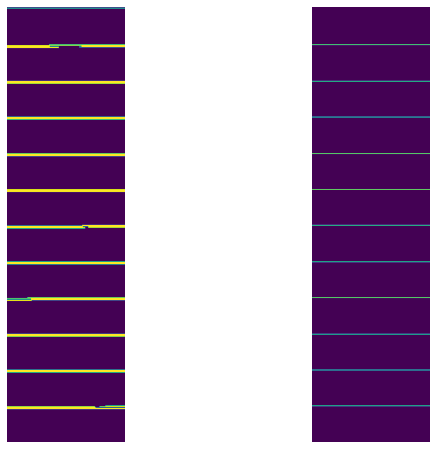

[50, 99, 147, 196, 244, 292, 341, 389, 438, 486, 534]


In [223]:
def crop_answer_area(image):
  
    # 수평선 detection
    bfilter = cv2.bilateralFilter(image.copy(), -1, 17, 17)
    edged = cv2.Canny(bfilter, 30, 100) 
    _, thresh = cv2.threshold(edged.copy(), 200, 255, cv2.THRESH_BINARY) 
    mask = thresh.copy()
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 2))
    mask = cv2.dilate(mask, kernel, iterations=1) 
    horizontal_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (50,1))
    horizontal_mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, horizontal_kernel, iterations=1)
    
    # horizontal_mask에서 여러개 잡히는 수평선 y좌표 삭제하고 하나만 뽑아냄
    lines = [i for i,j in enumerate(horizontal_mask) if sum(j) != 0]
    line_diff = drop_dupli_lines(lines,2)

    horizontal_del_dup = np.zeros(shape=horizontal_mask.shape)
    for i in line_diff:
        horizontal_del_dup[i] = [255]*horizontal_mask.shape[1]
    show_two_images(horizontal_mask, horizontal_del_dup)
    print(line_diff)
#     try:
#         if len(line_diff) > 2:
#             new_section = image[line_diff[2]:line_diff[-1],:]
#             plt.imshow(new_section)
#         else:
#             new_section = image[line_diff[0]:line_diff[-1],:]
#             plt.imshow(new_section)
#     except:
#         pass
    return line_diff

line_diff = crop_answer_area(c_img)
# image_A = crop_img.copy()

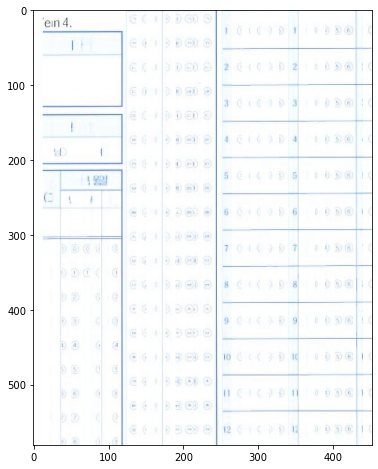

In [159]:
def concat_recog_points(image, criteria_list, margin):
    pp = list()
    for y_crit in criteria_list:
#         section = image[:,y_crit-margin:y_crit+12+margin]
        section = image[candidates[-3][0][0][0][1]:candidates[-3][0][0][0][1]+candidates[-3][2], y_crit[0]-margin:y_crit[0]+y_crit[2]+margin]
        pp.append(section)
    plt.imshow(cv2.hconcat(pp))
    
concat_recog_points(image_a, criteria_list, 3)

In [11]:
test_img = image.copy()
y_val = 787
margin = 16
line_list = sorted([(y_val - i*margin) for i in range(y_val//margin)])
x1, y1 = 0, y_val
x2, y2 = image.shape[1], y_val
# y_points = list()
# for line in line_list:
#     x1, x2 = 0, 1170
#     y1, y2 = line, line
#     cv2.line(test_img, (x1, y1), (x2, y2), (0, 255, 0), thickness=1)
    
questions_y = line_list[10:15] + line_list[16:21] + line_list[22:27] + line_list[28:33] + line_list[34:39] + line_list[40:45]
# print(questions_y)
for i in questions_y:
    cv2.line(test_img, (x1, i), (x2, i), (0, 255, 0), thickness=1)
    
cv2.imshow('dd',test_img)
cv2.waitKey(0)
cv2.destroyAllWindows(0)

NameError: name 'waitKey' is not defined

In [ ]:
def crop_answer_area(img, a, b, mar):
    recog_img, recog_cand, recog_area, criteria_list, y_list = draw_recogntion_point(img)
    # recognition rectangle 보다 아래쪽에 있는 수평선 잡기 위한 장치
    recog_mean = np.mean([i[1] for i in criteria_list])
    idx_a = criteria_list[a]
    idx_b = criteria_list[b]
    margin = mar
    section = recog_img[int(recog_mean):,idx_a[0]-margin:idx_b[0]+idx_b[2]+margin]
    
    # 수평선 detection
    bfilter = cv2.bilateralFilter(section.copy(), -1, 17, 17)
    edged = cv2.Canny(bfilter, 30, 100) 
    _, thresh = cv2.threshold(edged.copy(), 200, 255, cv2.THRESH_BINARY) 
    mask = thresh.copy()
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 2))
    mask = cv2.dilate(mask, kernel, iterations=1) 
    horizontal_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (50,1))
    horizontal_mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, horizontal_kernel, iterations=1)
    
    # horizontal_mask에서 여러개 잡히는 수평선 y좌표 삭제하고 하나만 뽑아냄
    lines = [i for i,j in enumerate(horizontal_mask) if sum(j) != 0 and i>recog_mean]
    line_diff = drop_dupli_lines(lines,2)

    horizontal_del_dup = np.zeros(shape=horizontal_mask.shape)
    for i in line_diff:
        horizontal_del_dup[i] = [255]*horizontal_mask.shape[1]
#     show_two_images(horizontal_mask, horizontal_del_dup)
    print(line_diff)
    try:
        if len(line_diff) > 2:
            new_section = section[line_diff[0]:line_diff[-1],:]
            plt.imshow(new_section)
        else:
            new_section = section[line_diff[0]:line_diff[-1],:]
            plt.imshow(new_section)
    except:
        new_section = section
        plt.imshow(new_section)
    return new_section

crop_img = crop_answer_area(recog_img,20,24,5)

In [ ]:
# data = pd.read_csv(os.path.join(DATA_DIR,"20-1.txt"), sep=" ", header=None)


# def get_coord(image, data):
#     img_w = image.shape[1]
#     img_h = image.shape[0]
#     candidates = list()
#     for i in range(len(data)):
#         x,y,w,h = data.iloc[i,1],data.iloc[i,2],data.iloc[i,3],data.iloc[i,4]
#         dw, dh = 1./img_w, 1./img_h
#         x, y, w, h = x/dw, y/dh, round(w/dw), round(h/dh) 
#         x1, y1 = round((2*x - w)/2), round((2*y - h)/2)
#         approx = np.zeros((4, 1, 2), dtype=np.int32)
#         approx[0][0][0], approx[0][0][1] = x1+w, y1
#         approx[1][0][0], approx[1][0][1] = x1+w, y1+h
#         approx[2][0][0], approx[2][0][1] = x1, y1+h
#         approx[3][0][0], approx[3][0][1] = x1, y1
#         candidates.append([approx,x1,y1,w,h])
#         cv2.drawContours(image, [approx], -1, (0, 255, 0), 2) 
#     return image, candidates
# image, candidates = get_coord(image, data)
# plt.imshow(image)

# def show_seperate_image(image, candidates):
#     sep_image_list = list()
#     for n, cand in enumerate(candidates):
#         c_img = image[cand[2]:cand[2]+cand[4], cand[1]:cand[1]+cand[3]]
#         sep_image_list.append(c_img)
#         print(n)
#         plt.imshow(c_img);
#         plt.show()
#     return sep_image_list
# sep_image_list = show_seperate_image(image_a, candidates)